In [1]:
import minerl
import numpy as np
import scipy
import tqdm
import scipy.misc
import gym
import os
import matplotlib.pyplot as plt

In [2]:
OUTDIR='/home/wguss/minerl/data_split/treechop'
data = minerl.data.make('MineRLTreechop-v0')

Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/process

In [31]:
sarsd_iter =data.sarsd_iter(num_epochs=1, max_sequence_len=-1, include_metadata=True)

In [32]:
sarsdm = next(sarsd_iter)

In [33]:
s,a,_,_,_,m = sarsdm

In [20]:
len_epis = []
for sarsdm in tqdm.tqdm(sarsd_iter):
    len_epis.append(len(sarsdm[2]))

157

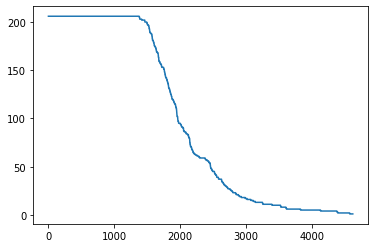

In [29]:
cdf = [(np.sum(np.array(len_epis) > x)) for x in range(max(len_epis)) ]
plt.plot(cdf)
cdf[1700]

In [3]:
MAX_EPI_LEN = 1700 # We are going to truncate files to this length.

In [65]:
a

{'attack': array([0, 0, 0, ..., 1, 1, 1]),
 'back': array([0, 0, 0, ..., 0, 0, 0]),
 'camera': array([[ 1.5       , -2.8499994 ],
        [ 2.5500011 , -3.8999996 ],
        [ 1.8000002 , -1.3500004 ],
        ...,
        [ 0.7500076 , -0.45000458],
        [ 0.7500076 , -0.6000061 ],
        [ 0.45000458, -0.45000458]], dtype=float32),
 'forward': array([1, 1, 1, ..., 0, 0, 0]),
 'jump': array([1, 1, 1, ..., 0, 0, 0]),
 'left': array([0, 0, 0, ..., 0, 0, 0]),
 'right': array([0, 1, 1, ..., 0, 0, 0]),
 'sneak': array([0, 0, 0, ..., 0, 0, 0]),
 'sprint': array([0, 0, 0, ..., 0, 0, 0])}

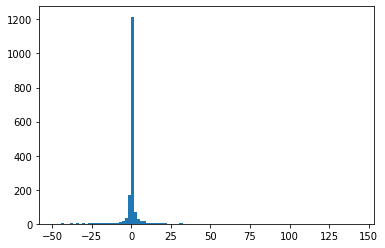

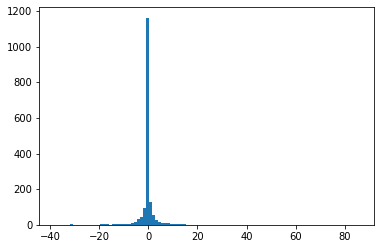

In [66]:
plt.hist((a['camera'][:,0]), bins=100)
plt.show()
plt.hist((a['camera'][:,1]), bins=100)
plt.show()

In [7]:
class TreechopDiscreteAction(gym.ActionWrapper):
    def __init__(self,env):
        super().__init__(env)
        self._orig_action_space = self.action_space
        self.action_space = gym.spaces.MultiDiscrete([2, 2, 3, 3, 2, 2, 2, 2, 2, 2])
        self.observation_space = self.observation_space.spaces['pov']
    def action(self, a):
        return TreechopDiscreteAction.s_action(a)
        
    def reverse_action(self, a):
        return TreechopDiscreteAction.s_reverse_action(a)
    
    @staticmethod
    def s_action(a,pitch_speed=20, yaw_speed=10):
        return {
            'attack': a[0],
            'back': a[1],
            'camera': np.array([
                (a[2] -1)*pitch_speed,
                (a[3] -1)*yaw_speed
            ]),
            'forward': a[4],
            'jump': a[5],
            'left': a[6],
            'right': a[7],
            'sneak': a[8],
            'sprint': a[9],
        }
    
    @staticmethod
    def s_reverse_action(a, batch=False):
        pitch = a['camera'][:, 0] if batch else a['camera'][0]
        yaw = a['camera'][:, 1] if batch else a['camera'][1]
        return np.array(([
            a['attack'],
            a['back'],
            np.sign(pitch)*(np.abs(pitch) > 1)+1,
            np.sign(yaw)*(np.abs(yaw) > 1)+1,
            a['forward'],
            a['jump'],
            a['left'],
            a['right'],
            a['sneak'],
            a['sprint']
        ]), dtype=np.int8)

### Split Dataset Maker

In [5]:
from PIL import Image

if not os.path.exists(OUTDIR): os.makedirs(OUTDIR)

obs = []
episode_starts = []
rewards = []
actions = []
episode_returns = []
for s,a,r,s,d,m in tqdm.tqdm(data.sarsd_iter(
    num_epochs=1, max_sequence_len=-1, include_metadata=True)):
    
    episode_starts.append(len(obs))
    rewards.extend(r.tolist())
    actions.append(TreechopDiscreteAction.s_reverse_action(a, batch=True))
    episode_returns.append(np.sum(r))
    
    # process img
    out_folder = os.path.join(OUTDIR, m['stream_name'])
    if not os.path.exists(out_folder): os.makedirs(out_folder)
    
    for i, pov in tqdm.tqdm(enumerate(s['pov'])):
        im_name = os.path.join(out_folder, '{}.png'.format(i))
        Image.fromarray(pov).save(im_name)
        obs.append(im_name)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
60it [00:00, 594.10it/s]
125it [00:00, 608.81it/s]
190it [00:00, 618.89it/s]
258it [00:00, 635.64it/s]
329it [00:00, 653.77it/s]
393it [00:00, 601.90it/s]
462it [00:00, 624.47it/s]
526it [00:00, 628.45it/s]
593it [00:00, 639.01it/s]
659it [00:01, 645.01it/s]
723it [00:01, 624.22it/s]
785it [00:01, 590.74it/s]
850it [00:01, 606.86it/s]
921it [00:01, 634.37it/s]
995it [00:01, 660.80it/s]
1062it [00:01, 633.71it/s]
1126it [00:01, 629.03it/s]
1192it [00:01, 637.04it/s]
1260it [00:01, 647.89it/s]
1328it [00:02, 655.90it/s]
1394it [00:02, 620.49it/s]
1457it [00:02, 598.42it/s]
1518it [00:02, 569.59it/s]
1595it [00:02, 617.09it/s]
1673it [00:02, 657.30it/s]
1752it [00:02, 691.19it/s]
1it [00:03,  3.80s/it]t/s]
0it [00:00, ?it/s]
84it [00:00, 831.95it/s]
166it [00:00, 827.04it/s]
237it [00:00, 786.87it/s]
324it [00:00, 807.53it/s]
438it [00:00, 884.05it/s]
534it [00:00, 904.97it/s]
620it [00:00, 888.93it/s]
730it [00:00, 941.40it/s]
847it [00:00, 999.40it/

878it [00:00, 1066.40it/s]
1005it [00:01, 1120.12it/s]
1132it [00:01, 1159.50it/s]
1262it [00:01, 1197.98it/s]
1383it [00:01, 1170.82it/s]
1501it [00:01, 1149.24it/s]
1626it [00:01, 1175.43it/s]
1751it [00:01, 1195.44it/s]
1876it [00:01, 1210.26it/s]
2007it [00:01, 1236.46it/s]
2135it [00:01, 1247.69it/s]
2261it [00:02, 1247.09it/s]
2387it [00:02, 1248.30it/s]
2514it [00:02, 1254.59it/s]
2640it [00:02, 1179.17it/s]
2763it [00:02, 1192.37it/s]
2894it [00:02, 1224.91it/s]
3025it [00:02, 1248.36it/s]
3156it [00:02, 1265.20it/s]
27it [00:59,  2.48s/it]t/s]
0it [00:00, ?it/s]
88it [00:00, 873.12it/s]
176it [00:00, 875.17it/s]
262it [00:00, 869.35it/s]
345it [00:00, 855.05it/s]
458it [00:00, 920.90it/s]
586it [00:00, 1005.50it/s]
713it [00:00, 1070.66it/s]
842it [00:00, 1126.21it/s]
967it [00:00, 1160.31it/s]
1094it [00:01, 1190.44it/s]
1219it [00:01, 1206.72it/s]
1343it [00:01, 1215.73it/s]
1465it [00:01, 1202.91it/s]
1586it [00:01, 1166.87it/s]
28it [01:00,  2.22s/it]t/s]
0it [00:00, ?it/s

1933it [00:02, 920.71it/s]
2038it [00:02, 954.10it/s]
2145it [00:02, 984.62it/s]
53it [01:53,  2.22s/it]/s]
0it [00:00, ?it/s]
84it [00:00, 833.10it/s]
165it [00:00, 825.78it/s]
238it [00:00, 792.68it/s]
315it [00:00, 784.76it/s]
396it [00:00, 790.64it/s]
502it [00:00, 854.42it/s]
604it [00:00, 896.77it/s]
703it [00:00, 921.96it/s]
813it [00:00, 968.37it/s]
914it [00:01, 978.92it/s]
1017it [00:01, 992.99it/s]
1116it [00:01, 971.89it/s]
1213it [00:01, 939.16it/s]
1307it [00:01, 927.65it/s]
1407it [00:01, 946.32it/s]
1504it [00:01, 951.48it/s]
1600it [00:01, 943.35it/s]
1698it [00:01, 952.28it/s]
1794it [00:01, 946.27it/s]
1889it [00:02, 943.41it/s]
1986it [00:02, 949.01it/s]
2081it [00:02, 940.73it/s]
54it [01:55,  2.29s/it]/s]
0it [00:00, ?it/s]
76it [00:00, 753.46it/s]
157it [00:00, 769.48it/s]
240it [00:00, 786.11it/s]
311it [00:00, 760.98it/s]
395it [00:00, 782.14it/s]
473it [00:00, 780.34it/s]
566it [00:00, 818.89it/s]
655it [00:00, 838.48it/s]
736it [00:00, 810.44it/s]
827it [00:0

89it [00:00, 888.46it/s]
174it [00:00, 875.73it/s]
276it [00:00, 912.53it/s]
393it [00:00, 976.00it/s]
521it [00:00, 1049.33it/s]
643it [00:00, 1094.62it/s]
771it [00:00, 1143.38it/s]
900it [00:00, 1182.61it/s]
1023it [00:00, 1195.57it/s]
1141it [00:01, 1171.88it/s]
1267it [00:01, 1195.09it/s]
1397it [00:01, 1223.64it/s]
1528it [00:01, 1246.88it/s]
1653it [00:01, 1241.53it/s]
80it [02:50,  1.89s/it]t/s]
0it [00:00, ?it/s]
91it [00:00, 901.29it/s]
182it [00:00, 902.97it/s]
272it [00:00, 901.51it/s]
353it [00:00, 868.17it/s]
446it [00:00, 883.45it/s]
542it [00:00, 904.49it/s]
654it [00:00, 958.12it/s]
782it [00:00, 1034.47it/s]
908it [00:00, 1092.72it/s]
1039it [00:01, 1148.81it/s]
1167it [00:01, 1184.07it/s]
1292it [00:01, 1202.81it/s]
1413it [00:01, 1202.05it/s]
1534it [00:01, 1157.94it/s]
1659it [00:01, 1182.73it/s]
1789it [00:01, 1213.96it/s]
1915it [00:01, 1225.21it/s]
81it [02:52,  1.88s/it]t/s]
0it [00:00, ?it/s]
87it [00:00, 860.72it/s]
175it [00:00, 865.59it/s]
286it [00:00, 925

530it [00:00, 1060.95it/s]
655it [00:00, 1109.27it/s]
786it [00:00, 1160.26it/s]
919it [00:00, 1206.33it/s]
1045it [00:00, 1220.65it/s]
1165it [00:01, 1185.10it/s]
1287it [00:01, 1195.29it/s]
1410it [00:01, 1204.84it/s]
1530it [00:01, 1182.39it/s]
1648it [00:01, 1179.61it/s]
1775it [00:01, 1204.75it/s]
1901it [00:01, 1220.53it/s]
2030it [00:01, 1240.19it/s]
2155it [00:01, 1241.25it/s]
2280it [00:01, 1241.54it/s]
2405it [00:02, 1216.73it/s]
2527it [00:02, 1215.03it/s]
2651it [00:02, 1222.14it/s]
2774it [00:02, 1222.25it/s]
108it [03:46,  2.20s/it]/s]
0it [00:00, ?it/s]
94it [00:00, 930.28it/s]
182it [00:00, 912.70it/s]
269it [00:00, 897.80it/s]
353it [00:00, 879.60it/s]
447it [00:00, 895.53it/s]
554it [00:00, 939.58it/s]
670it [00:00, 996.14it/s]
784it [00:00, 1033.75it/s]
910it [00:00, 1092.52it/s]
1034it [00:01, 1132.42it/s]
1155it [00:01, 1152.78it/s]
1280it [00:01, 1179.11it/s]
1407it [00:01, 1203.12it/s]
1528it [00:01, 1175.09it/s]
1649it [00:01, 1183.91it/s]
109it [03:47,  2.03s/i

503it [00:00, 1007.80it/s]
630it [00:00, 1072.49it/s]
759it [00:00, 1129.22it/s]
890it [00:00, 1176.97it/s]
1014it [00:00, 1193.21it/s]
1142it [00:01, 1215.75it/s]
1276it [00:01, 1249.46it/s]
1401it [00:01, 1183.93it/s]
1525it [00:01, 1197.77it/s]
1652it [00:01, 1216.99it/s]
1778it [00:01, 1227.34it/s]
1905it [00:01, 1239.60it/s]
2030it [00:01, 1201.73it/s]
133it [04:41,  1.94s/it]/s]
0it [00:00, ?it/s]
76it [00:00, 756.86it/s]
151it [00:00, 752.24it/s]
228it [00:00, 756.51it/s]
303it [00:00, 753.24it/s]
402it [00:00, 810.08it/s]
517it [00:00, 888.81it/s]
638it [00:00, 965.58it/s]
760it [00:00, 1028.58it/s]
882it [00:00, 1078.86it/s]
1003it [00:01, 1114.94it/s]
1124it [00:01, 1141.04it/s]
1239it [00:01, 1107.84it/s]
1351it [00:01, 1078.77it/s]
1469it [00:01, 1105.77it/s]
1592it [00:01, 1139.09it/s]
1714it [00:01, 1159.99it/s]
134it [04:42,  1.89s/it]/s]
0it [00:00, ?it/s]
90it [00:00, 895.74it/s]
172it [00:00, 869.58it/s]
263it [00:00, 881.06it/s]
366it [00:00, 919.49it/s]
469it [00:00

1335it [00:01, 1066.60it/s]
1443it [00:01, 1056.92it/s]
1559it [00:01, 1085.48it/s]
1676it [00:01, 1109.10it/s]
158it [05:36,  1.85s/it]/s]
0it [00:00, ?it/s]
84it [00:00, 834.61it/s]
168it [00:00, 833.89it/s]
269it [00:00, 878.43it/s]
369it [00:00, 910.49it/s]
504it [00:00, 1008.21it/s]
626it [00:00, 1062.80it/s]
746it [00:00, 1100.35it/s]
876it [00:00, 1152.30it/s]
996it [00:00, 1165.64it/s]
1122it [00:01, 1190.23it/s]
1245it [00:01, 1200.49it/s]
1369it [00:01, 1210.21it/s]
159it [05:37,  1.69s/it]/s]
0it [00:00, ?it/s]
83it [00:00, 825.16it/s]
171it [00:00, 839.65it/s]
268it [00:00, 872.67it/s]
354it [00:00, 868.64it/s]
480it [00:00, 957.00it/s]
608it [00:00, 1034.78it/s]
737it [00:00, 1098.37it/s]
862it [00:00, 1138.74it/s]
978it [00:00, 1140.88it/s]
1091it [00:01, 1127.06it/s]
1203it [00:01, 1118.56it/s]
1334it [00:01, 1167.73it/s]
1464it [00:01, 1202.62it/s]
1589it [00:01, 1215.25it/s]
1716it [00:01, 1229.93it/s]
160it [05:39,  1.73s/it]/s]
0it [00:00, ?it/s]
83it [00:00, 827.17i

1408it [00:01, 1152.70it/s]
1533it [00:01, 1179.28it/s]
1658it [00:01, 1197.23it/s]
184it [06:32,  2.01s/it]/s]
0it [00:00, ?it/s]
91it [00:00, 901.21it/s]
179it [00:00, 893.50it/s]
280it [00:00, 924.01it/s]
381it [00:00, 946.59it/s]
493it [00:00, 992.61it/s]
619it [00:00, 1060.02it/s]
745it [00:00, 1111.96it/s]
871it [00:00, 1152.44it/s]
990it [00:00, 1162.30it/s]
1106it [00:01, 1161.00it/s]
1232it [00:01, 1187.19it/s]
1360it [00:01, 1212.88it/s]
1481it [00:01, 1191.83it/s]
1605it [00:01, 1205.57it/s]
1726it [00:01, 1121.84it/s]
1847it [00:01, 1146.45it/s]
1974it [00:01, 1179.52it/s]
2101it [00:01, 1204.82it/s]
185it [06:34,  2.01s/it]/s]
0it [00:00, ?it/s]
85it [00:00, 847.64it/s]
169it [00:00, 844.97it/s]
255it [00:00, 847.53it/s]
365it [00:00, 909.56it/s]
460it [00:00, 919.65it/s]
579it [00:00, 986.89it/s]
701it [00:00, 1046.42it/s]
830it [00:00, 1108.08it/s]
952it [00:00, 1137.81it/s]
1071it [00:01, 1152.81it/s]
1195it [00:01, 1177.49it/s]
1313it [00:01, 1168.77it/s]
1439it [00:01

In [23]:
x = episode_returns
un_fucked_episodic_returns = [x[0]] +[x[i] - x[i-1] for i in range(len(episode_returns))[1:]]

In [35]:
stacked_actions = np.hstack(actions).T

In [39]:
np.savez(os.path.join(OUTDIR, 'stable.npz'),
         obs=obs, 
         rewards=rewards, 
         actions=stacked_actions, 
         episode_returns=un_fucked_episodic_returns,
         episode_starts=episode_starts)

In [3]:
y = np.load(os.path.join(OUTDIR, 'stable.npz'))

In [4]:
from stable_baselines.gail import ExpertDataset
dataset = ExpertDataset(expert_path=os.path.join(OUTDIR, 'stable.npz'),
                        traj_limitation=-1, batch_size=128)

obs (443759,)
rewards (443759,)
actions (443759, 10)
episode_returns (207,)
episode_starts (207,)
Total trajectories: -1
Total transitions: 443759
Average returns: 64.1256038647343
Std for returns: 0.3725762219257747


In [5]:
dataset.plot()

<Figure size 640x480 with 1 Axes>

In [6]:
tr = dataset.train_loader

In [7]:
tr.start_process()

In [8]:
sample = next(tr)

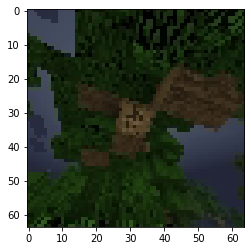

{'attack': 1, 'back': 0, 'camera': array([0, 0]), 'forward': 0, 'jump': 0, 'left': 0, 'right': 0, 'sneak': 0, 'sprint': 0}


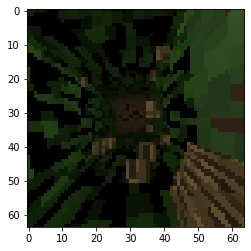

{'attack': 1, 'back': 0, 'camera': array([ 0, 10]), 'forward': 0, 'jump': 0, 'left': 0, 'right': 0, 'sneak': 0, 'sprint': 0}


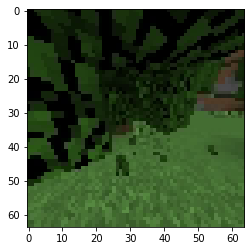

{'attack': 1, 'back': 0, 'camera': array([-20, -10]), 'forward': 0, 'jump': 0, 'left': 0, 'right': 0, 'sneak': 0, 'sprint': 0}


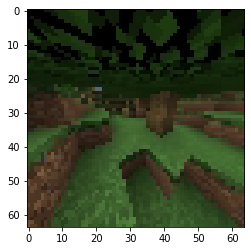

{'attack': 0, 'back': 0, 'camera': array([20, 10]), 'forward': 1, 'jump': 0, 'left': 0, 'right': 0, 'sneak': 0, 'sprint': 0}


In [13]:
for x in range(4):
    plt.imshow(sample[0][x]); plt.show()
    print(TreechopDiscreteAction.s_action(sample[1][x]))

In [5]:
from stable_baselines import A2C

In [15]:
env = gym.make('MineRLTreechop-v0')

In [18]:
wrappedEnv = TreechopDiscreteAction(env)

In [8]:
from stable_baselines.common.vec_env import DummyVecEnv
env = DummyVecEnv([lambda: TreechopDiscreteAction(gym.make('MineRLTreechop-v0'))])

In [9]:
model = A2C('CnnPolicy', env, verbose=1)

W0716 09:13:46.455500 140097306027840 deprecation_wrapper.py:119] From /home/wguss/.local/lib/python3.6/site-packages/stable_baselines/common/tf_util.py:98: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0716 09:13:46.457252 140097306027840 deprecation_wrapper.py:119] From /home/wguss/.local/lib/python3.6/site-packages/stable_baselines/common/tf_util.py:107: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0716 09:13:46.840122 140097306027840 deprecation_wrapper.py:119] From /home/wguss/.local/lib/python3.6/site-packages/stable_baselines/common/policies.py:114: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0716 09:13:46.841608 140097306027840 deprecation_wrapper.py:119] From /home/wguss/.local/lib/python3.6/site-packages/stable_baselines/common/input.py:25: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 09:13:46.853424 14009730602

In [27]:
model.pretrain(dataset, n_epochs=1000)

AssertionError: Only Discrete and Box action spaces are supported

In [37]:
import tensorflow as tf
def _get_pretrain_placeholders(self):
    policy = self.train_model
    print(self.action_space)
    if (isinstance(self.action_space, gym.spaces.Discrete) or
        isinstance(self.action_space, gym.spaces.MultiDiscrete)):
        return policy.obs_ph, self.actions_ph, policy.policy
    return policy.obs_ph, self.actions_ph, policy.deterministic_action

def pretrain(self, dataset, n_epochs=10, learning_rate=1e-4,
                 adam_epsilon=1e-8, val_interval=None):
    """
    Pretrain a model using behavior cloning:
    supervised learning given an expert dataset.

    NOTE: only Box and Discrete spaces are supported for now.

    :param dataset: (ExpertDataset) Dataset manager
    :param n_epochs: (int) Number of iterations on the training set
    :param learning_rate: (float) Learning rate
    :param adam_epsilon: (float) the epsilon value for the adam optimizer
    :param val_interval: (int) Report training and validation losses every n epochs.
        By default, every 10th of the maximum number of epochs.
    :return: (BaseRLModel) the pretrained model
    """
    continuous_actions = isinstance(self.action_space, gym.spaces.Box)
    discrete_actions = isinstance(self.action_space, gym.spaces.Discrete)
    multidiscrete_actions = isinstance(self.action_space, gym.spaces.MultiDiscrete)
    assert discrete_actions or continuous_actions or multidiscrete_actions, 'Only Discrete, Box, or MultiDiscrete action spaces are supported'

    # Validate the model every 10% of the total number of iteration
    if val_interval is None:
        # Prevent modulo by zero
        if n_epochs < 10:
            val_interval = 1
        else:
            val_interval = int(n_epochs / 10)

    with self.graph.as_default():
        with tf.variable_scope('fixed_pretrain_2'):
            if continuous_actions:
                obs_ph, actions_ph, deterministic_actions_ph = self._get_pretrain_placeholders()
                loss = tf.reduce_mean(tf.square(actions_ph - deterministic_actions_ph))
            elif discrete_actions:
                obs_ph, actions_ph, actions_logits_ph = self._get_pretrain_placeholders()
                # actions_ph has a shape if (n_batch,), we reshape it to (n_batch, 1)
                # so no additional changes is needed in the dataloader
                actions_ph = tf.expand_dims(actions_ph, axis=1)
                one_hot_actions = tf.one_hot(actions_ph, self.action_space.n)
                loss = tf.nn.softmax_cross_entropy_with_logits_v2(
                    logits=actions_logits_ph,
                    labels=tf.stop_gradient(one_hot_actions)
                )
                loss = tf.reduce_mean(loss)
            elif multidiscrete_actions:
                losses = []
                obs_ph, actions_ph, logits = _get_pretrain_placeholders(self)
                
                n_actions = len(self.action_space.nvec)
                action_indices = [0] + np.cumsum(self.action_space.nvec).tolist()
                action_phs = [tf.one_hot(actions_ph[:,i], depth=self.action_space.nvec[i]) for i in range(n_actions)]
                
                action_logits_phs = [
                    logits[:, action_indices[i]:action_indices[i+1]] for i in range(n_actions)
                ]
                
                for one_hot_actions, action_logits_ph in zip(action_phs, action_logits_phs):
                    print(one_hot_actions, action_logits_ph)
                    loss_for_subspace = tf.nn.softmax_cross_entropy_with_logits_v2(
                        logits=action_logits_ph,
                        labels=tf.stop_gradient(one_hot_actions)
                    )
                    loss_for_subspace = tf.reduce_mean(loss_for_subspace)
                    losses.append(loss_for_subspace)

                loss = tf.math.add_n(losses)
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=adam_epsilon)
            optim_op = optimizer.minimize(loss, var_list=self.params)

        self.sess.run(tf.global_variables_initializer())

    if self.verbose > 0:
        print("Pretraining with Behavior Cloning...")

    for epoch_idx in range(int(n_epochs)):
        train_loss = 0.0
        # Full pass on the training set
        for _ in tqdm.tqdm(range(len(dataset.train_loader))):
            expert_obs, expert_actions = dataset.get_next_batch('train')
            feed_dict = {
                obs_ph: expert_obs,
                actions_ph: expert_actions,
            }
            train_loss_, _ = self.sess.run([loss, optim_op], feed_dict)
            train_loss += train_loss_

        train_loss /= len(dataset.train_loader)

        if self.verbose > 0 and (epoch_idx + 1) % val_interval == 0:
            val_loss = 0.0
            # Full pass on the validation set
            for _ in range(len(dataset.val_loader)):
                expert_obs, expert_actions = dataset.get_next_batch('val')
                val_loss_, = self.sess.run([loss], {obs_ph: expert_obs,
                                                    actions_ph: expert_actions})
                val_loss += val_loss_

            val_loss /= len(dataset.val_loader)
            if self.verbose > 0:
                print("==== Training progress {:.2f}% ====".format(100 * (epoch_idx + 1) / n_epochs))
                print('Epoch {}'.format(epoch_idx + 1))
                print("Training loss: {:.6f}, Validation loss: {:.6f}".format(train_loss, val_loss))
                print()
        # Free memory
        del expert_obs, expert_actions
    if self.verbose > 0:
        print("Pretraining done.")
    return self

In [ ]:
model.verbose = 1
pretrain(model, dataset, n_epochs=1000)

MultiDiscrete([2 2 3 3 2 2 2 2 2 2])
Tensor("fixed_pretrain_2/one_hot:0", shape=(?, 2), dtype=float32) Tensor("fixed_pretrain_2/strided_slice_10:0", shape=(?, 2), dtype=float32)
Tensor("fixed_pretrain_2/one_hot_1:0", shape=(?, 2), dtype=float32) Tensor("fixed_pretrain_2/strided_slice_11:0", shape=(?, 2), dtype=float32)
Tensor("fixed_pretrain_2/one_hot_2:0", shape=(?, 3), dtype=float32) Tensor("fixed_pretrain_2/strided_slice_12:0", shape=(?, 3), dtype=float32)
Tensor("fixed_pretrain_2/one_hot_3:0", shape=(?, 3), dtype=float32) Tensor("fixed_pretrain_2/strided_slice_13:0", shape=(?, 3), dtype=float32)
Tensor("fixed_pretrain_2/one_hot_4:0", shape=(?, 2), dtype=float32) Tensor("fixed_pretrain_2/strided_slice_14:0", shape=(?, 2), dtype=float32)
Tensor("fixed_pretrain_2/one_hot_5:0", shape=(?, 2), dtype=float32) Tensor("fixed_pretrain_2/strided_slice_15:0", shape=(?, 2), dtype=float32)
Tensor("fixed_pretrain_2/one_hot_6:0", shape=(?, 2), dtype=float32) Tensor("fixed_pretrain_2/strided_slice_

  0%|          | 0/2427 [00:00<?, ?it/s]

Pretraining with Behavior Cloning...


In [11]:
x = np.array([1,2,3,4,5])
[0] + np.cumsum(x).tolist() 

[0, 1, 3, 6, 10, 15]